In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score
import matplotlib.gridspec as gridspec
import seaborn as sns


# Create the dataset
data = {
    'Quizzes': [5.3, 5.5, 5.5, 5.0, 2.5, 3.0, 3.0, 3.1, 3.5, 3.5, 3.7, 4.0, 4.0, 4.0, 4.0, 5.7],
    'Labs': [5.3, 5.9, 5.29, 4.35, 5.5, 5.0, 4.0, 3.1, 4.5, 5.62, 5.0, 3.0, 4.0, 5.75, 4.44, 5.9],
    'Final': [4.818, 5.773, 4.464, 5.069, 4.164, 4.091, 3.727, 3.909, 3.518, 4.897, 5.209, 3.0, 3.091, 5.818, 4.069, 5.77]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Augmenting data by replicating and adding noise
np.random.seed(42)
augmented = []
for i in range(len(df)):
    row = df.iloc[i]
    for _ in range(10):  # Create 10 variations of each record
        noise = np.random.normal(0, 0.2, 3)  # Add Gaussian noise with mean=0 and std=0.2
        new_row = row + noise
        # Ensure values are within boundaries (grades must be between 2 and 6)
        new_row = new_row.clip(2, 6)
        augmented.append(new_row)

# Create augmented DataFrame
df_aug = pd.DataFrame(augmented, columns=df.columns)

# categorical target
# Above 4.0 = "Pass" (1), Below or equal to 4.0 = "Fail" (0)
df_aug['Pass'] = (df_aug['Final'] > 4).astype(int)

# data preparation
X = df_aug[['Labs']]
y = df_aug['Final']
y_class = df_aug['Pass']

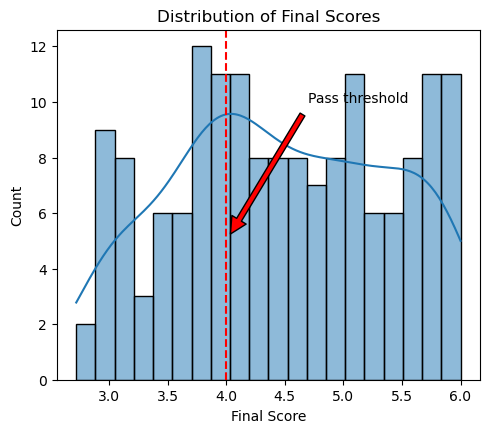

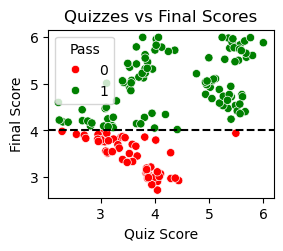

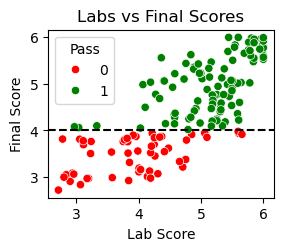

In [9]:
plt.figure(figsize=(12, 10))

# Plot 1: Distribution of Final scores
plt.subplot(2, 2, 1)
sns.histplot(df_aug['Final'], bins=20, kde=True)
plt.axvline(x=4, color='red', linestyle='--')
plt.title('Distribution of Final Scores')
plt.xlabel('Final Score')
plt.ylabel('Count')
plt.annotate('Pass threshold', xy=(4, 5), xytext=(4.7, 10), 
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()
# Plot 2: Scatter plot of Quizzes vs Final with Pass/Fail coloring
plt.subplot(2, 2, 2)
sns.scatterplot(data=df_aug, x='Quizzes', y='Final', hue='Pass', palette=['red', 'green'])
plt.axhline(y=4, color='black', linestyle='--')
plt.title('Quizzes vs Final Scores')
plt.xlabel('Quiz Score')
plt.ylabel('Final Score')
plt.show()
# Plot 3: Scatter plot of Labs vs Final with Pass/Fail coloring
plt.subplot(2, 2, 3)
sns.scatterplot(data=df_aug, x='Labs', y='Final', hue='Pass', palette=['red', 'green'])
plt.axhline(y=4, color='black', linestyle='--')
plt.title('Labs vs Final Scores')
plt.xlabel('Lab Score')
plt.ylabel('Final Score')
plt.show()
# Plot 4: Scatter plot of Quizzes vs Labs with Pass/Fail coloring
plt.subplot(2, 2, 4)
sns.scatterplot(data=df_aug, x='Quizzes', y='Labs', hue='Pass', palette=['red', 'green'])
plt.title('Quizzes vs Labs Scores')
plt.xlabel('Quiz Score')
plt.ylabel('Lab Score')

plt.tight_layout()
plt.savefig('data_distribution.png')
plt.close()
plt.show()

In [10]:
# Fit linear regression model (only using Labs as feature)
linear_model = LinearRegression()
linear_model.fit(X, y)
linear_pred = linear_model.predict(X)

# smoothing data
X_smooth = np.linspace(2, 6, 100).reshape(-1, 1)
linear_pred_smooth = linear_model.predict(X_smooth)

/Users/alisarupenyan/anaconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


/Users/alisarupenyan/anaconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Users/alisarupenyan/anaconda3/envs/ML_env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


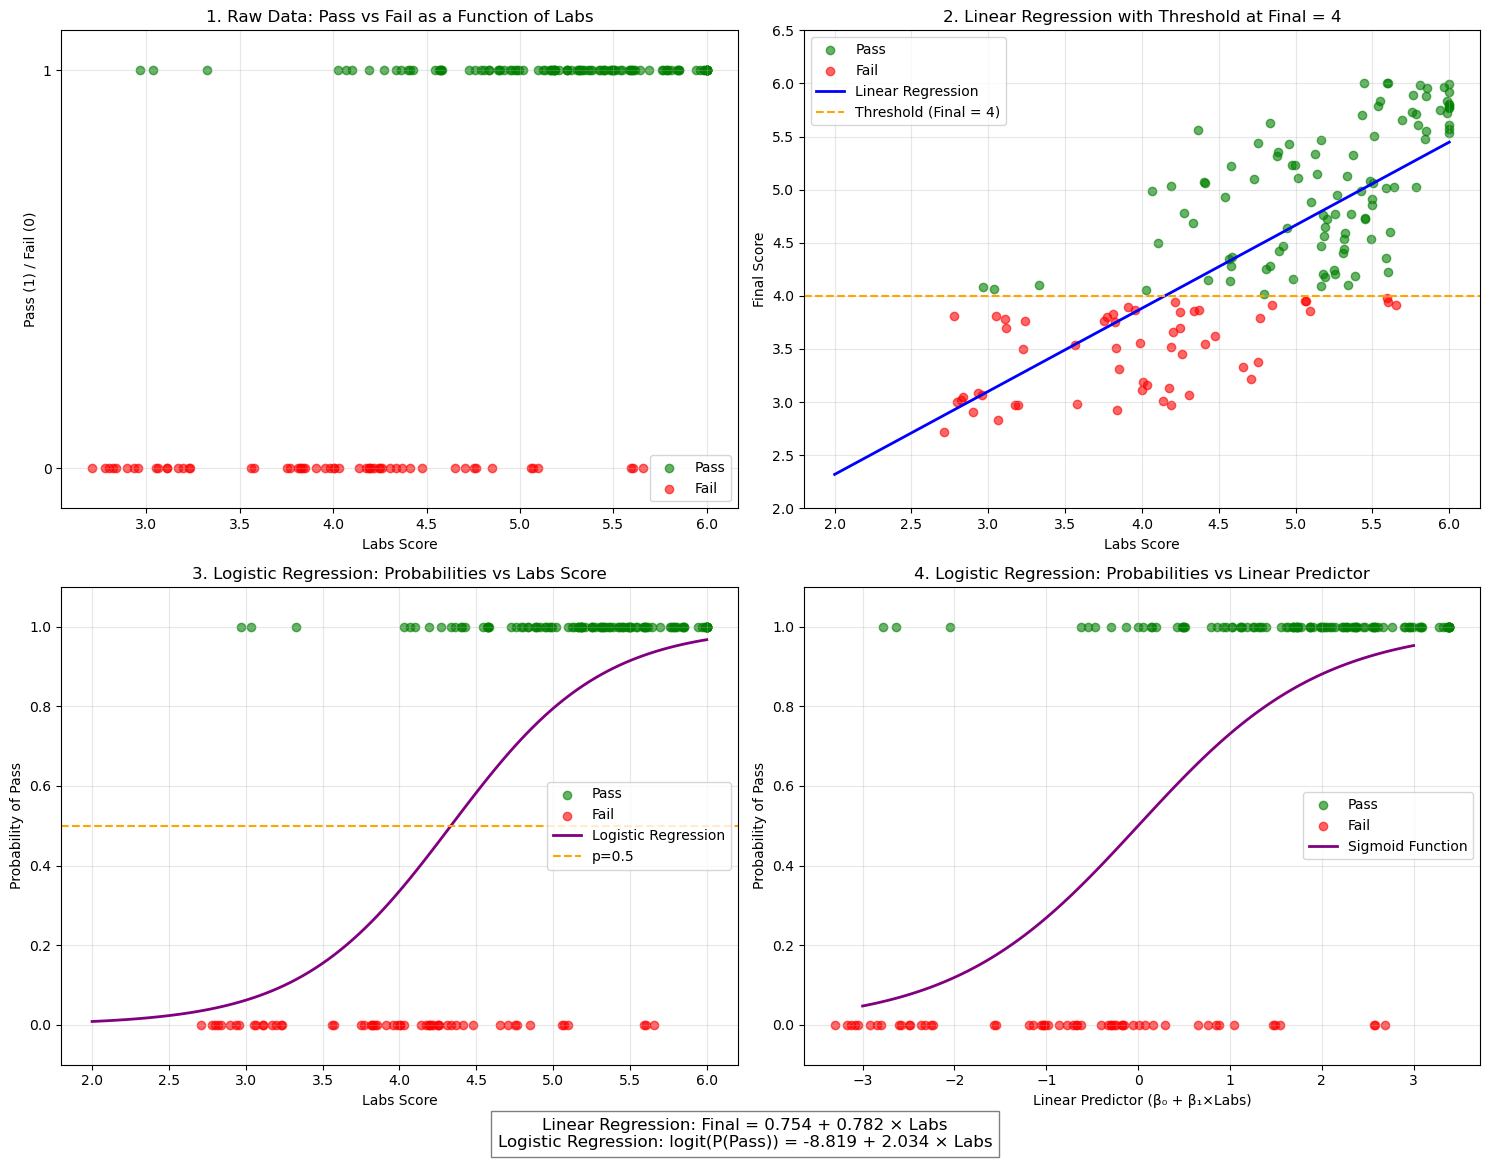

Linear Regression: Final = 0.754 + 0.782 × Labs
Linear Model R²: 0.593
Logistic Regression: logit(P(Pass)) = -8.819 + 2.034 × Labs


In [6]:
# Fit logistic regression model
logistic_model = LogisticRegression(random_state=42)
logistic_model.fit(X, y_class)
logistic_pred_prob = logistic_model.predict_proba(X)[:, 1]  # Probability of pass

# Generate smooth curve for logistic regression
logistic_pred_prob_smooth = logistic_model.predict_proba(X_smooth)[:, 1]

# Calculate the linear predictor (z=theta_0+theta_1*x) for both raw and smooth data
linear_predictor = logistic_model.decision_function(X)
linear_predictor_smooth = logistic_model.decision_function(X_smooth)


plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 2)

# 1) Raw data of pass vs fail as a function of Labs
ax1 = plt.subplot(gs[0, 0])
ax1.scatter(df_aug.loc[df_aug['Pass'] == 1, 'Labs'], 
           df_aug.loc[df_aug['Pass'] == 1, 'Pass'], 
           c='green', label='Pass', alpha=0.6)
ax1.scatter(df_aug.loc[df_aug['Pass'] == 0, 'Labs'], 
           df_aug.loc[df_aug['Pass'] == 0, 'Pass'], 
           c='red', label='Fail', alpha=0.6)
ax1.set_xlabel('Labs Score')
ax1.set_ylabel('Pass (1) / Fail (0)')
ax1.set_title('1. Raw Data: Pass vs Fail as a Function of Labs')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(-0.1, 1.1)
ax1.set_yticks([0, 1])

# 2) Linear regression with a threshold at 4
ax2 = plt.subplot(gs[0, 1])
ax2.scatter(df_aug.loc[df_aug['Pass'] == 1, 'Labs'], 
           df_aug.loc[df_aug['Pass'] == 1, 'Final'], 
           c='green', label='Pass', alpha=0.6)
ax2.scatter(df_aug.loc[df_aug['Pass'] == 0, 'Labs'], 
           df_aug.loc[df_aug['Pass'] == 0, 'Final'], 
           c='red', label='Fail', alpha=0.6)
ax2.plot(X_smooth, linear_pred_smooth, 'b-', linewidth=2, label='Linear Regression')
ax2.axhline(y=4, color='orange', linestyle='--', label='Threshold (Final = 4)')


ax2.set_xlabel('Labs Score')
ax2.set_ylabel('Final Score')


ax2.set_title('2. Linear Regression with Threshold at Final = 4')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(2, 6.5)

# 3. Logistic regression showing probabilities as a function of Labs
ax3 = plt.subplot(gs[1, 0])
# Plot pass/fail points at their actual 0/1 values
ax3.scatter(df_aug.loc[df_aug['Pass'] == 1, 'Labs'], 
           np.ones(len(df_aug.loc[df_aug['Pass'] == 1])),
           c='green', label='Pass', alpha=0.6)
ax3.scatter(df_aug.loc[df_aug['Pass'] == 0, 'Labs'], 
           np.zeros(len(df_aug.loc[df_aug['Pass'] == 0])),
           c='red', label='Fail', alpha=0.6)
# Plotting the logistic regression curve
ax3.plot(X_smooth, logistic_pred_prob_smooth, 'purple', linewidth=2, label='Logistic Regression')
ax3.axhline(y=0.5, color='orange', linestyle='--', label='p=0.5')
ax3.set_xlabel('Labs Score')
ax3.set_ylabel('Probability of Pass')
ax3.set_title('3. Logistic Regression: Probabilities vs Labs Score')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_ylim(-0.1, 1.1)

# 4. Logistic regression showing probabilities as a function of linear predictor
ax4 = plt.subplot(gs[1, 1])
# Plot points colored by their actual pass/fail status
ax4.scatter(linear_predictor[y_class == 1], 
           np.ones(sum(y_class == 1)),
           c='green', label='Pass', alpha=0.6)
ax4.scatter(linear_predictor[y_class == 0], 
           np.zeros(sum(y_class == 0)),
           c='red', label='Fail', alpha=0.6)
# Plotting the sigmoid function
sigmoid = lambda x: 1 / (1 + np.exp(-x))
x_range = np.linspace(-3, 3, 100)
ax4.plot(x_range, sigmoid(x_range), 'purple', linewidth=2, label='Sigmoid Function')
ax4.set_xlabel('Linear Predictor (β₀ + β₁×Labs)')
ax4.set_ylabel('Probability of Pass')
ax4.set_title('4. Logistic Regression: Probabilities vs Linear Predictor')
ax4.grid(True, alpha=0.3)
ax4.legend()
ax4.set_ylim(-0.1, 1.1)

# model information
plt.figtext(0.5, 0.01, 
           f"Linear Regression: Final = {linear_model.intercept_:.3f} + {linear_model.coef_[0]:.3f} × Labs\n"
           f"Logistic Regression: logit(P(Pass)) = {logistic_model.intercept_[0]:.3f} + {logistic_model.coef_[0][0]:.3f} × Labs",
           ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
#plt.suptitle('Labs Scores vs Final Exam Outcomes: Linear and Logistic Regression', fontsize=16)
plt.show()

# Print model coefficients
print(f"Linear Regression: Final = {linear_model.intercept_:.3f} + {linear_model.coef_[0]:.3f} × Labs")
print(f"Linear Model R²: {r2_score(y, linear_pred):.3f}")
print(f"Logistic Regression: logit(P(Pass)) = {logistic_model.intercept_[0]:.3f} + {logistic_model.coef_[0][0]:.3f} × Labs")

# Gradient descent training

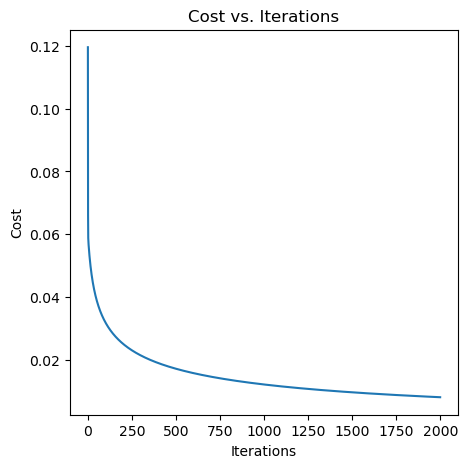

In [11]:


class LogisticRegressionGradientDescent:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.theta = None
        self.cost_history = []
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def compute_cost(self, X, y, theta):
        m = len(y)
        h = self.sigmoid(np.dot(X, theta))
        
        # Avoid log(0) with small epsilon
        epsilon = 1e-15
        h = np.clip(h, epsilon, 1 - epsilon)
        
        # Compute cost
        cost = -1/m * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return cost
    
    def gradient_descent(self, X, y):
        m, n = X.shape
        theta = np.zeros(n)
        
        for _ in range(self.num_iterations):
            # Compute hypothesis
            h = self.sigmoid(np.dot(X, theta))
            
            # Compute gradient
            gradient = 1/m * np.dot(X.T, (h - y))
            
            # Update parameters
            theta -= self.learning_rate * gradient
            
            # Track cost
            cost = self.compute_cost(X, y, theta)
            self.cost_history.append(cost)
        
        return theta
    
    def fit(self, X, y):
        # Add intercept term
        X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))
        
        # Run gradient descent
        self.theta = self.gradient_descent(X_with_intercept, y)
        return self
    
    def predict_proba(self, X):
        # Add intercept term
        X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))
        return self.sigmoid(np.dot(X_with_intercept, self.theta))
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# Demonstration
def gradient_descent_demo():
    # Generate synthetic data
    np.random.seed(42)
    X = np.random.randn(100, 2)
    y = (X[:, 0] + X[:, 1] > 0).astype(int)
    
    # Create and train model
    model = LogisticRegressionGradientDescent(
        learning_rate=25.8, # note the large number!
        num_iterations=2000
    )
    model.fit(X, y)
    
    # Visualize cost convergence
    plt.figure(figsize=(5, 5))
    plt.plot(model.cost_history)
    plt.title('Cost vs. Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.show()
    
    return model

# Run the demonstration
model = gradient_descent_demo()